In [45]:
import numpy as np
import scipy.linalg as linalg
from dtuimldmtools import similarity
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pyplot import figure, legend, plot, show, xlabel, ylabel
# exercise 8.1.1
import torch
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.io import loadmat
from sklearn import model_selection
from dtuimldmtools import draw_neural_net, train_neural_net


from dtuimldmtools import rlr_validate

# fetch dataset 
# wine = fetch_ucirepo(id=109) 
  
# # data (as pandas dataframes) 
# X = wine.data.features 
# y = wine.data.targets 

# totaldata= (wine.data)
  
# metadata 
# print(wine.metadata) 
  
# variable information 
# print(wine.variables) 

# OFFLINE LOADING OF DATA
X = np.loadtxt('../wine/wine.data', delimiter=',')
y = X[:,0]
X = np.delete(X,0,axis=1)
# y = np.loadtxt('./wine/wine.names', delimiter=',')

Xorig = X
# Standardizing the data

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# One of K encoding
# y = similarity.one_of_k(y)

# Ensure y values are within the range of the identity matrix's size
num_classes = int(np.max(y)) + 1
y2 = np.eye(num_classes)[y.astype(int)]

#removing first column of y
y2 = y2[:,1:]

#Appending y to X
X = np.append(X,y2,axis=1)

#Extracting the first column of X
y = X[:,0]



attributeNames = [
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"
]

#Removing the first column of X
X = np.delete(X,0,axis=1)
# Removing alcohol from attributenames
attributeNames = attributeNames[1:]


Training model of type:

Sequential(
  (0): Linear(in_features=16, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	1.0129617	1.2945212e-06
		Final loss:
		1039	1.0129158	9.4151295e-07

	Best loss: 1.012915849685669


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		859	0.9401994	9.509354e-07

	Best loss: 0.9401993751525879


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	1.0481839	1.2510214e-06
		Final loss:
		1041	1.048135	9.098765e-07

	Best loss: 1.0481350421905518



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

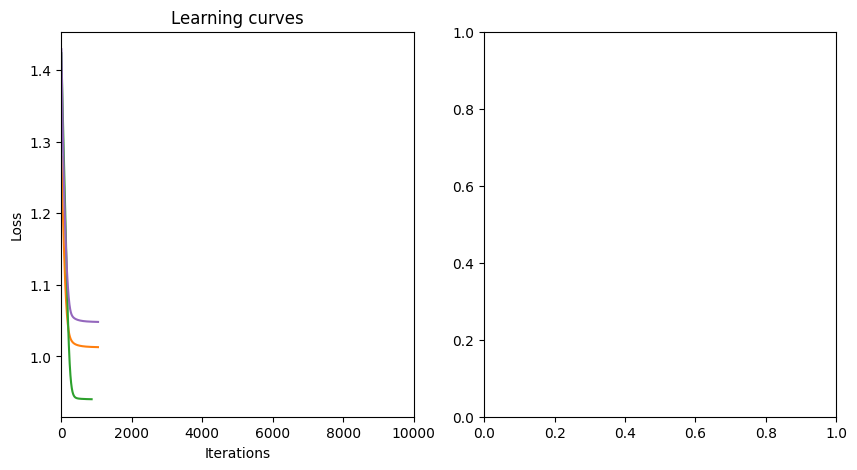

In [ ]:
#Generalization error
#two-fold K=10 fold cross validation 
# K = 10
# N = X.shape[0]
# M = X.shape[1]
# #splitting the data into K folds
# fold_size = N//K
# np.random.shuffle(X)
# folds = np.split(X, K)

N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames + ["Class 1", "Class 2", "Class 3"]
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10

CV = model_selection.KFold(K, shuffle=True)

# Creating a nested cross-validation
# Nested cross-validation
nested_cv = model_selection.KFold(n_splits=K, shuffle=True, random_state=1)

#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-4, 10))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))


# For ANN
# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000


# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop



k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    
    
    # Now we want to make a ANN to model the data
    
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")
    
    
    k += 1

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()


show()

# Display the results for the best cross-validation fold
# finding the index for the lowest test error
lowest_error_index = np.argmin(Error_test_rlr)
k = lowest_error_index
print("the lowest error index is: ", k)
print("all the errors are: ", Error_test_rlr)
figure(k, figsize=(12, 8))
subplot(1, 2, 1)
semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
xlabel("Regularization factor")
ylabel("Mean Coefficient Values")
grid()
# You can choose to display the legend, but it's omitted for a cleaner
# plot, since there are many attributes
# legend(attributeNames[1:], loc='best')

subplot(1, 2, 2)
title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
loglog(
    lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
)
xlabel("Regularization factor")
ylabel("Squared error (crossvalidation)")
legend(["Train error", "Validation error"])
grid()

# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in best fold:")
# print(M)
# print(attributeNames)
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, k], 2)))

print("Ran Exercise 8.1.1")




Training model of type:

Sequential(
  (0): Linear(in_features=3, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss


/Users/lauge/Desktop/ML/MLenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([118])) that is different to the input size (torch.Size([118, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.9787705	1.9487152e-06
		Final loss:
		1214	0.9784425	9.746851e-07

	Best loss: 0.9784424901008606


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss


/Users/lauge/Desktop/ML/MLenv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
/Users/lauge/Desktop/ML/MLenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([119])) that is different to the input size (torch.Size([119, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	1.0900854	7.76434e-06
		2000	1.0847493	2.6374898e-06
		Final loss:
		2689	1.0834274	9.902672e-07

	Best loss: 1.0834274291992188


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		735	0.9282369	9.631904e-07

	Best loss: 0.9282369017601013



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

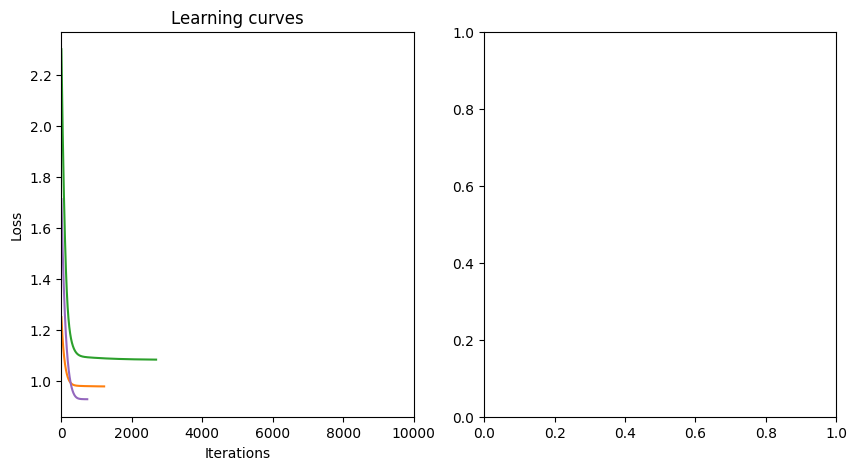

In [ ]:

## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = True
if do_pca_preprocessing:
    Y = stats.zscore(X, 0)
    U, S, V = np.linalg.svd(Y, full_matrices=False)
    V = V.T
    # Components to be included as features
    k_pca = 3
    X = X @ V[:, :k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
K = 3  # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()

print("Ran Exercise 8.2.5")
